In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import pylcp.atom as atom
from pylcp.common import bisectFindChangeValue, progressBar
import cProfile, pstats, io
from pstats import SortKey
savefigs = True

### Let's now set up the units:

Whatever units we use, let's run numbers that are realistic for a common atom, Rb.:

In [2]:
rb87 = atom('87Rb')

klab = 2*np.pi*rb87.transition[1].k # Lab wavevector (without 2pi) in cm^{-1}
taulab = rb87.state[2].tau  # Lifetime of 6P_{3/2} state (in seconds)
gammalab = 1/taulab 
Bplab = 15 # About 15 G/cm is a typical gradient for Rb
masslab = rb87.mass

print(klab, taulab, gammalab/2/np.pi, masslab)

80528.75481555492 2.62348e-08 6066558.277246076 1.4598096126471075e-25


Set up all three unit sytems in a reasonable function:

In [3]:
def return_units(unit_system):
    if unit_system == 'default':
        # Now, here are our `natural' length and time scales:
        x0 = 1/klab  # cm
        t0 = taulab  # s

        # And now our wavevector, decay rate, and magnetic field gradient in these units:
        k = klab*x0
        gamma = gammalab*t0
        alpha = cts.value('Bohr magneton')*1e-4*Bplab*x0*t0/cts.hbar
        mass = masslab*(x0*1e-2)**2/cts.hbar/t0
        
    elif unit_system == 'magnetic_gradient':
        # Now, here are our `natural' length and time scales:
        x0 = cts.hbar*gammalab/(cts.value('Bohr magneton')*1e-4*Bplab) # cm
        t0 = klab*x0*taulab # s

        # And now our wavevector, decay rate, and magnetic field gradient in these units:
        k = klab*x0
        gamma = gammalab*t0
        alpha = 1.0*gamma     # The magnetic field gradient parameter
        mass = masslab*(x0*1e-2)**2/cts.hbar/t0
        
    elif unit_system == 'hybrid':
        x0 = cts.hbar*gammalab/(cts.value('Bohr magneton')*1e-4*Bplab) # cm
        t0 = klab*x0/gammalab

        k=1
        gamma=1
        alpha=1

        mass = masslab/(cts.hbar*(klab*1e2)**2*t0)
    else:
        raise ValueError('Unit system %s not recognized', unit_system)
        
    return mass, k, gamma, alpha, x0, t0

unit_systems = ['default', 'magnetic_gradient', 'hybrid']
for unit_system in unit_systems:
    print(return_units(unit_system))

(813.6550657404823, 1.0, 1.0, 4.297436175809039e-05, 1.2417924532552691e-05, 2.62348e-08)
(18933499.706654813, 23269.688230139665, 23269.688230139665, 23269.688230139665, 0.28896123233790394, 0.0006104756167800681)
(0.034966307141434304, 1, 1, 1, 0.28896123233790394, 0.0006104756167800681)


### Now test all three units

To see if there (a) is a difference in performance and (b) is a difference of solution

Force profile for hybrid units:
Completed in 13.93 s.                                               
Trajectories for hybrid units:
Completed in 5.70 s.                                                
         3146856 function calls (3105913 primitive calls) in 5.707 seconds

   Ordered by: internal time
   List reduced from 183 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4466    0.836    0.000    3.394    0.001 rateeq.py:212(__calc_pumping_rates)
     4466    0.646    0.000    0.748    0.000 rateeq.py:352(force)
   156312    0.566    0.000    0.566    0.000 {method 'reduce' of 'numpy.ufunc' objects}
373801/332858    0.529    0.000    2.325    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    26796    0.325    0.000    0.813    0.000 numeric.py:913(tensordot)
     4466    0.274    0.000    1.265    0.000 fields.py:945(project_pol)
    26796    0.233    0.000    0.730    0.000 fields.py:833(b

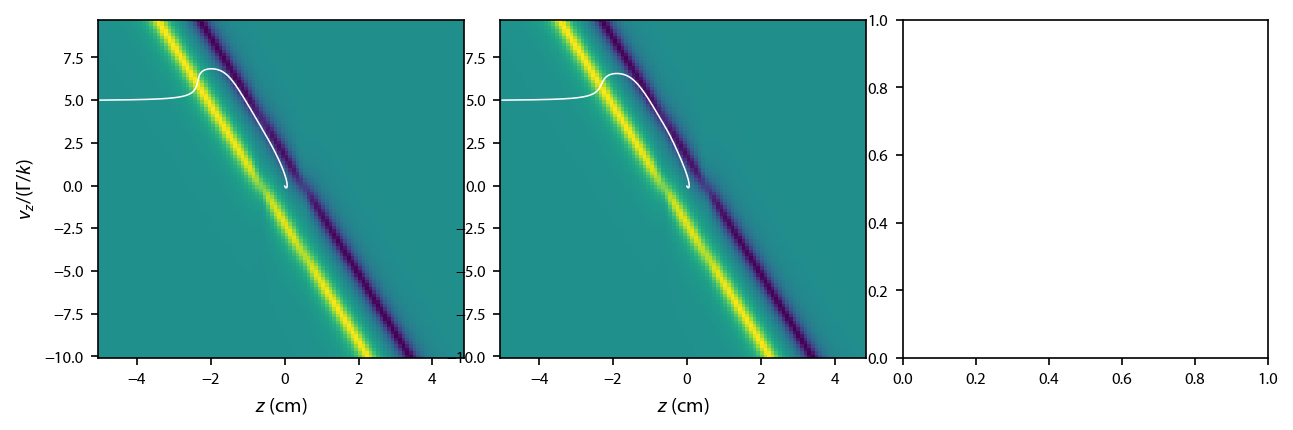

In [7]:
units_to_test = ['hybrid', 'default', 'magnetic_gradient']
atols = [
    np.array([1e-6, 1e-6, 1e-6, 1e-6, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]),
    np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6])
]
rtols = [1e-6, 1e-3, 1e-3]
max_step_for_units = [0.01, np.inf, np.inf]

fig, ax = plt.subplots(1, len(units_to_test),
                       figsize = (len(units_to_test)*3.25, 2.75))

if not isinstance(ax, np.ndarray):
    ax = [ax]

for ii, (unit_system, max_step, atol, rtol) in enumerate(zip(units_to_test, max_step_for_units, atols, rtols)):
    mass, k, gamma, alpha, x0, t0 = return_units(unit_system)
    
    # Define the atomic Hamiltonian:
    Hg, mugq = pylcp.hamiltonians.singleF(F=0, muB=1)
    He, mueq = pylcp.hamiltonians.singleF(F=1, muB=1)

    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

    hamiltonian = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

    det = -2.*gamma
    beta = 1.5

    # Define the laser beams:
    laserBeams = pylcp.conventional3DMOTBeams(
        beta=beta, delta=det, wb=10./x0, k=k,
        beam_type=pylcp.gaussianBeam
    )
    
    magField = pylcp.quadrupoleMagneticField(alpha)
    
    rateeq = pylcp.rateeq(laserBeams, magField, hamiltonian,
                          include_mag_forces=False)
    
    z = np.arange(-5, 5.0, 0.1)/x0
    vz = np.arange(-10, 10, 0.2)
    
    dz = np.mean(np.diff(z))
    dvz = np.mean(np.diff(vz))
    
    [Z, VZ] = np.meshgrid(z, vz)
    
    print('Force profile for %s units:' % unit_system)
    rateeq.generate_force_profile(
        np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z]),
        np.array([np.zeros(Z.shape), np.zeros(Z.shape), VZ]),
        name='Fz_vs_z_and_vz',
        progress_bar = True)
    
    ax[ii].imshow(
        rateeq.profile['Fz_vs_z_and_vz'].F[2],
        origin='bottom',
        extent=((np.amin(z)-dz/2)*x0, (np.amax(z)-dz/2)*x0,
                np.amin(vz)-dvz/2, np.amax(vz)-dvz/2),
        aspect='auto'
    )
    
    def captured_condition(t, y):
        if(y[-4]<1e-5 and y[-1]<1e-3/x0):
            val = -1.
        else:
            val = 1.

        return val

    def lost_condition(t, y):
        if y[-1]>5./x0:
            val = -1.
        else:
            val = 1.

        return val

    captured_condition.terminal=True
    lost_condition.terminal=True

    print('Trajectories for %s units:' % unit_system)
    pr = cProfile.Profile()
    for jj, v_i in enumerate([5.]):
        rateeq.set_initial_position(np.array([0., 0., -5/x0]))
        rateeq.set_initial_velocity(np.array([0., 0., v_i]))
        rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
        pr.enable()
        rateeq.evolve_motion([0, 1e-2/t0],
                             events=[captured_condition, lost_condition],
                             max_step=max_step,
                             atol=atol,
                             rtol=rtol,
                             progress_bar=True)
        pr.disable()
        ax[ii].plot(rateeq.sol.r[2]*x0, rateeq.sol.v[2], 'w-', linewidth=0.75)
    
    s = io.StringIO()
    sortby = SortKey.TIME
    ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats(sortby)
    ps.sort_stats(sortby).print_stats(20)
    print(s.getvalue())
    
    ax[ii].set_xlabel('$z$ (cm)')
    if ii==0:
        ax[ii].set_ylabel('$v_z/(\Gamma/k)$')

In [5]:
np.maximum(np.abs(np.concatenate((rateeq.sol.N[:, 10001], rateeq.sol.v[:, 10001], rateeq.sol.r[:, 10001]))),
           np.abs(np.concatenate((rateeq.sol.N[:, 10000], rateeq.sol.v[:, 10000], rateeq.sol.r[:, 10000]))))

array([0.00100092, 0.00100001, 0.00100006, 0.001     , 0.001     ,
       0.001     , 0.0010051 , 0.001     , 0.001     , 0.00101097])

In [ ]:
if isinstance(pol, int) or isinstance(pol, float):
    if pol>0:
        pol = np.array([1., -1j, 0.])/np.sqrt(2)
    else:
        pol = np.array([1., +1j, 0.])/np.sqrt(2)
        
        